In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim



In [18]:
df = pd.read_csv("data 3.csv", encoding="latin1", low_memory=False)

df.head()



,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [19]:
x = df["no2"].dropna().values

print(len(x))



419509


In [20]:
r = 102317059

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)

print("a_r =", a_r)
print("b_r =", b_r)


a_r = 2.5
b_r = 1.5


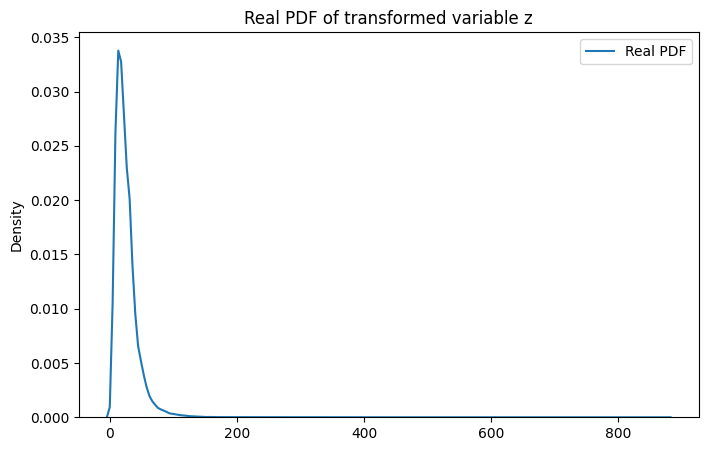

In [21]:
plt.figure(figsize=(8,5))
sns.kdeplot(z, label="Real PDF")
plt.title("Real PDF of transformed variable z")
plt.legend()
plt.show()



In [22]:
real_data = torch.tensor(z, dtype=torch.float32).view(-1,1)



In [23]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),

            nn.Linear(16,16),
            nn.ReLU(),

            nn.Linear(16,1)
        )

    def forward(self,x):
        return self.net(x)


In [24]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),

            nn.Linear(16,16),
            nn.ReLU(),

            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.net(x)


In [25]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)


In [26]:
epochs = 2000
batch_size = 64

D_losses = []
G_losses = []

for epoch in range(epochs):

    idx = np.random.randint(0, len(real_data), batch_size)

    real = real_data[idx]

    noise = torch.randn(batch_size,1)

    fake = G(noise)

    # Train Discriminator

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = criterion(D_real, torch.ones_like(D_real)) + \
             criterion(D_fake, torch.zeros_like(D_fake))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # Train Generator

    noise = torch.randn(batch_size,1)

    fake = G(noise)

    loss_G = criterion(D(fake), torch.ones_like(D(fake)))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    D_losses.append(loss_D.item())
    G_losses.append(loss_G.item())

    if epoch % 200 == 0:
        print("Epoch:", epoch, "D Loss:", loss_D.item(), "G Loss:", loss_G.item())


Epoch: 0 D Loss: 4.144927501678467 G Loss: 0.8008599281311035
Epoch: 200 D Loss: 0.7983672022819519 G Loss: 1.2320483922958374
Epoch: 400 D Loss: 1.468896508216858 G Loss: 0.8658967018127441
Epoch: 600 D Loss: 1.3767590522766113 G Loss: 0.7633532881736755
Epoch: 800 D Loss: 1.3859636783599854 G Loss: 0.6587125062942505
Epoch: 1000 D Loss: 1.3863091468811035 G Loss: 0.6746391654014587
Epoch: 1200 D Loss: 1.3856887817382812 G Loss: 0.693813145160675
Epoch: 1400 D Loss: 1.366774082183838 G Loss: 0.6671478152275085
Epoch: 1600 D Loss: 1.3380897045135498 G Loss: 0.6945425868034363
Epoch: 1800 D Loss: 1.3615920543670654 G Loss: 0.7770207524299622


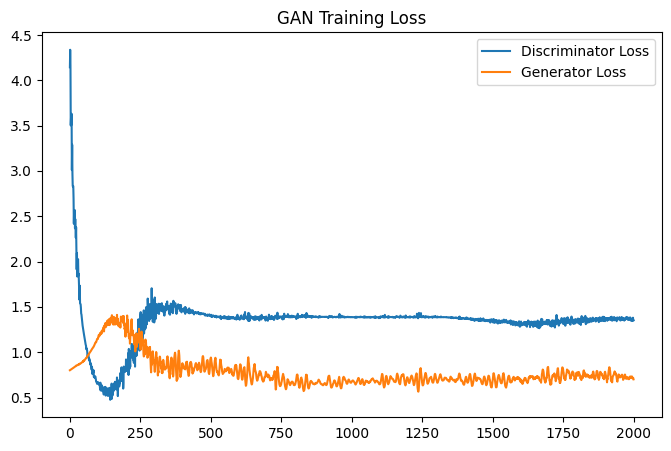

In [27]:
plt.figure(figsize=(8,5))

plt.plot(D_losses,label="Discriminator Loss")
plt.plot(G_losses,label="Generator Loss")

plt.legend()

plt.title("GAN Training Loss")

plt.show()


In [28]:
noise = torch.randn(5000,1)

generated = G(noise).detach().numpy()


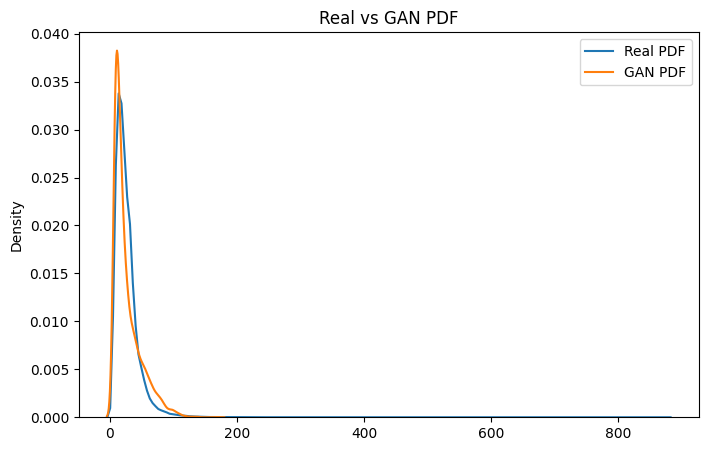

In [29]:
plt.figure(figsize=(8,5))

sns.kdeplot(z,label="Real PDF")

sns.kdeplot(generated.flatten(),label="GAN PDF")

plt.legend()

plt.title("Real vs GAN PDF")

plt.show()
